In [25]:
import numpy as np, matplotlib.pyplot as plt, ast
import neurokit2 as nk
from scipy.signal import find_peaks, sosfiltfilt, butter
SCI_PY_METHOD = 0
DB_DIFF_METHOD = 1
def find_r_peaks (env : np.ndarray, method : int = SCI_PY_METHOD) -> None:
    if method == SCI_PY_METHOD:
    # --------------    Method 1    ----------------
        '''
            scipy.find_peaks method which specializes in searching for jumps in data (enabling R-Peaks to be)
            easily identifiable.
        '''
        indices, _ = find_peaks(env[:,1], distance=150, prominence=.5)
        time_vals = sorted([env[:,0][index] for index in indices])
        volt_vals = np.interp(time_vals, env[:,0], env[:,1])
        return time_vals, volt_vals

    elif method == DB_DIFF_METHOD:
    # ------------      Method 2        -------------
        '''
            Double difference method proposed in: 
            https://www.sciencedirect.com/science/article/pii/S2212017312004227
            (UNFINISHED)
        '''
        voltages = env[:,1]
        dif1 = []
        for i in range(0, len(voltages)-1):
            dif1.append(voltages[i+1] - voltages[i])

        dif2 = []
        for j in range(0, len(dif1) -1):
            dif2.append(dif1[j+1] - dif1[j])
        
        db_diff = np.array(dif2) ** 2
        times = np.delete(times, [len(times) - 1, len(times) - 2])
        
        peak_differences = np.hstack((np.vstack(times), np.vstack(db_diff)))
        peak_differences = peak_differences[peak_differences[:,1].argsort()[::-1]]

        max = peak_differences[0][1]
        threshold = max * 0.03
        selected = []

        # Optimize via combining different ranges together.
        coverage = list()
        for i in range(1, len(peak_differences)):
            if peak_differences[i][1] < threshold:
                break

            range_exists = False
            for ranges in coverage:
                if ranges[0] <= peak_differences[i][0] and peak_differences[i][0] <= ranges[1]:
                    range_exists = True
                    break
            if not range_exists:
                selected.append(peak_differences[i])
                coverage.append((peak_differences[i][0] - 0.075, peak_differences[i][0] + 0.075))
        
        return selected
    return

def computeHRV(r_peak_times) :
    rr_intervals = []
    prev = r_peak_times[0]
    for i in range(1, len(r_peak_times)):
        rr_intervals.append(r_peak_times[i] - prev)
        prev = r_peak_times[i]

    rr_intervals = np.array(rr_intervals) * 1000
    prev = rr_intervals[0]
    sum_of_squared_diff = 0
    for i in range(1, len(rr_intervals)):
        rr_diff = rr_intervals[i] - prev
        sum_of_squared_diff += rr_diff ** 2
    print("sum_of_squared_diff: ", sum_of_squared_diff)
    print("1/(N-1): ", 1/(len(rr_intervals) - 1))
    RMSSD = np.sqrt(sum_of_squared_diff / (len(rr_intervals) - 1))
    print("RMSSD: ", RMSSD)
    return RMSSD

def low_pass_filter(data : np.ndarray, cutoff : float, sample_rate : float, poles : int):
    sos = butter(poles, cutoff, 'lowpass', fs=sample_rate, output="sos")
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

def band_pass_filter(data : np.ndarray, lower : float, upper: float, sample_rate : float, poles : int):
    sos = butter(poles, [lower, upper], 'bandpass', fs=sample_rate, output="sos")
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [20]:
file_time = open("../data/test_ecg_time.json", "r")
times = ast.literal_eval(file_time.read())
file_time.close()

file_voltage = open("../data/test_ecg_voltage.json", "r")
voltages = ast.literal_eval(file_voltage.read())
file_voltage.close()

(0.0, 20000.0)

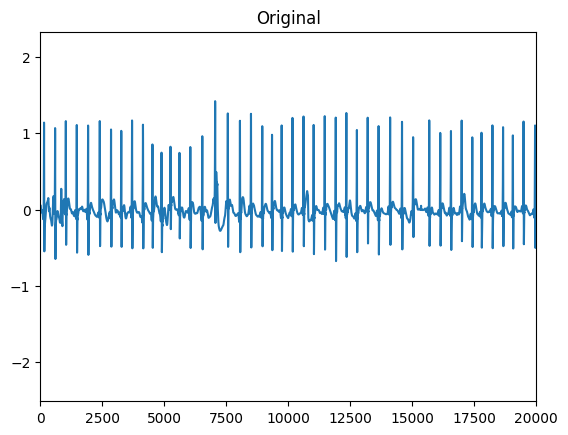

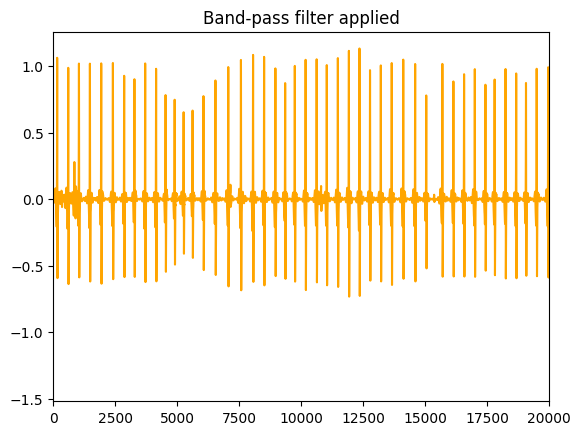

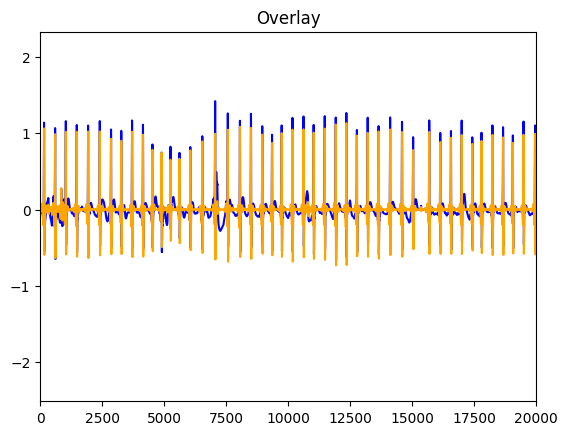

In [21]:

plt.figure("1")
plt.title("Original")
plt.plot(voltages)
plt.xlim(0, 20000)

plt.figure("2")
plt.title("Band-pass filter applied")
filtered_voltages = band_pass_filter(voltages, 10, 100, 1000, 5)
# plt.figure("2")
plt.plot(filtered_voltages, color="orange")
plt.xlim(0, 20000)

plt.figure("4")
plt.title("Overlay")
plt.plot(voltages, color="blue")
plt.plot(filtered_voltages, color="orange")
plt.xlim(0, 20000)

[0.3010100336677889, 1.1720390679689323, 2.01506716890563, 2.8780959365312175, 3.770125670855695, 4.689156305210173, 5.576185872862428, 6.383212773759125, 7.23224107470249, 8.092269742324744, 8.838294609820327, 9.552318410613687, 10.258341944731491, 10.964365478849295, 11.82039401313377, 12.764425480849361, 13.775459181972732, 14.773492449748325, 15.728524284142804, 16.597553251775057, 17.4865828860962, 18.25560852028401, 19.013633787792926, 19.865662188739623, 20.73669122304077, 21.53371779059302, 22.405746858228607, 23.273775792526415, 24.10880362678756, 24.939831327710923, 25.788859628654286, 26.647888262942097, 27.555918530617685, 28.49194973165772, 29.36697889929664] 35
[0.3010100336677889, 1.1730391013033767, 2.01506716890563, 2.879095969865662, 3.770125670855695, 4.690156338544618, 5.578185939531317, 6.3842128070935695, 7.23224107470249, 8.092269742324744, 8.838294609820327, 9.55331844394813, 10.259341978065935, 10.96536551218374, 11.82239407980266, 12.765425514183805, 13.775459

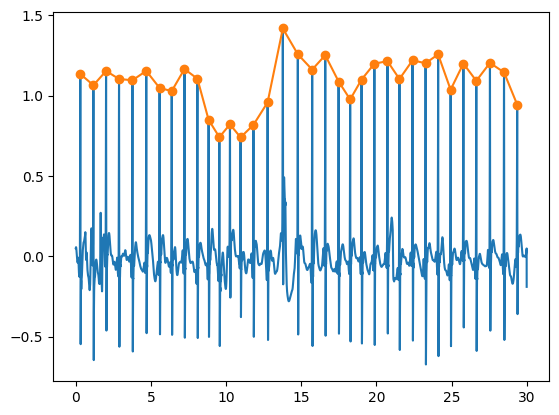

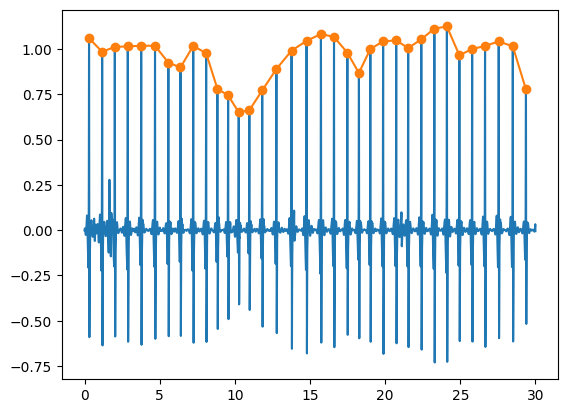

In [22]:
est_t = np.linspace(0, 30, 30000)
est_v = np.array(np.interp(est_t, times, voltages))
tv_input = np.hstack((np.vstack(est_t), np.vstack(est_v)))
peak_time, peak_volt = find_r_peaks(tv_input)

est_v_new = np.array(np.interp(est_t, times, filtered_voltages))
tv_input_new = np.hstack((np.vstack(est_t), np.vstack(est_v_new)))
peak_time_new, peak_volt_new = find_r_peaks(tv_input_new)

plt.figure("3")
plt.plot(est_t, est_v)
plt.plot(peak_time, peak_volt, marker="o")

plt.figure("5")
plt.plot(est_t, est_v_new)
plt.plot(peak_time_new, peak_volt_new, marker="o")

print(sorted((peak_time)), len(peak_time))
print(sorted((peak_time_new)), len(peak_time_new))

sum_of_squared_diff:  190107.6736336775
1/(N-1):  0.030303030303030304
RMSSD:  75.90018837236127
Original w/o filter 75.90018837236127 


sum_of_squared_diff:  190606.706902008
1/(N-1):  0.030303030303030304
RMSSD:  75.99974220490728
New w/ filter 75.99974220490728
2
2
(array([ 2353,  5033,  5575,  8305, 10600, 13584, 16087, 18332, 20734,
       23690, 25793, 27772]), {})
(array([  912,  9563,  9911, 10055, 10235, 13757, 13878, 14597, 14765,
       14933, 15584, 15726, 15915, 16431, 16589, 16740, 17320, 17482,
       18262, 18861, 19005, 19140, 19849, 19990, 20564, 20729, 20895,
       21071, 21242, 21372, 21526, 21705, 22079, 22235, 22398, 22568,
       22762, 22899, 23093, 23263, 23413, 23913, 24099, 24261, 24805,
       24937, 25625, 25779, 25916, 26632, 26780, 27400, 27552, 28333,
       28486, 28651, 28815, 29181, 29357, 29516, 29674, 29792]), {})


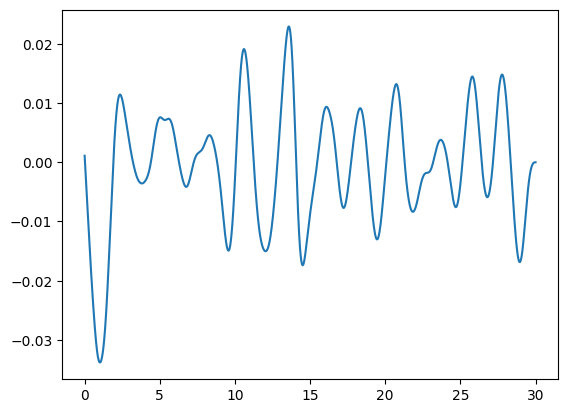

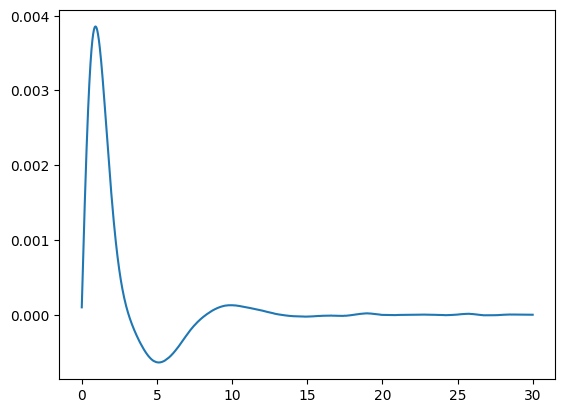

In [31]:
hrv = computeHRV(peak_time)
print("Original w/o filter", hrv, "\n\n")

hrv_new = computeHRV(peak_time_new)
print("New w/ filter", hrv_new)

print(len(find_peaks(nk.ecg_rsp(est_v))))
print(len(find_peaks(nk.ecg_rsp(est_v_new))))

plt.figure("rsp1")
plt.plot(est_t, nk.ecg_rsp(est_v))
print(find_peaks(nk.ecg_rsp(est_v)))

plt.figure("rsp2")
plt.plot(est_t, nk.ecg_rsp(est_v_new))
print(find_peaks(nk.ecg_rsp(est_v_new)))